# Recognition Parametrized Model (RPM): Peer Supervision


Observations $\mathcal{X} = \{ x_j \}$ are groups of MNIST images representing $J$ different renderings of the same digit. The RPM to extract this information without explicit label information - a setting that might be termed "peer-supervision". The model writes:

$$ \mathsf{P_{\theta}}(\mathcal{X}, \mathcal{Z}) = \mathsf{p_{\theta_z}}(\mathcal{Z}) \prod_{j} \left( \mathsf{p_{0,j}}(\mathsf{x_{j}}) \frac{\mathsf{f_{\theta j}}(\mathsf{\mathcal{Z}} | \mathsf{x_{j}})}{\mathsf{F_{\theta j}}(\mathcal{Z})} \right) $$

## Load and Rearanged MNIST

In [1]:
import pickle
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from utils_process import plot_loss

import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

from utils_demo import rearrange_mnist

from fast_rpm import RPM
import torch.nn.functional as F


data_folder = './../MNIST'

# Load MNIST
train_data = datasets.MNIST(
    root=data_folder,
    train=True,
    transform=ToTensor(),
    download=True,
)

test_data = datasets.MNIST(
    root=data_folder,
    train=False,
    transform=ToTensor()
)

# Random seeds
torch.manual_seed(2)

# Number of Conditionally independent Factors
num_factors = 2

# Sub-Sample original dataset
train_length = 60000

# Keep Only some digits (for efficiency)
sub_ids = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
sub_ids = torch.tensor([0, 1, 2, 3, 4])
num_digits = len(sub_ids)

# Rearrange MNIST by grouping num_factors Conditionally independent Observations together
observations, train_images, train_labels = rearrange_mnist(
    train_data.train_data, 
    train_data.train_labels, 
    num_factors, 
    train_length=train_length,
    sub_ids=sub_ids
)


# Rearrange MNIST by grouping num_factors Conditionally independent Observations together
observations_test, test_images, test_labels = rearrange_mnist(
    test_data.test_data, 
    test_data.test_labels, 
    num_factors, 
    train_length=test_data.test_labels.shape[0],
    sub_ids=sub_ids
)
test_labels = test_labels.reshape(observations_test[0].shape[0], num_factors)
            

/nfs/ghome/live/hugos/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/nfs/ghome/live/hugos/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/nfs/ghome/live/hugos/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/nfs/ghome/live/hugos/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


## Typical Observations

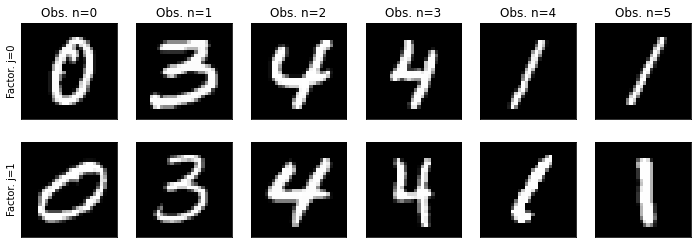

In [3]:
num_plot = np.arange(6)
plt.figure(figsize=(len(num_plot)*2, num_factors*2))
for obsi in range(len(num_plot)):
    for facti in range(num_factors):
        plt.subplot(num_factors, len(num_plot), (1+obsi) + facti * len(num_plot))
        plt.imshow(observations[facti][num_plot[obsi], :, :], cmap='gray')
        plt.xticks([])
        plt.yticks([])
        if facti == 0:
            plt.title('Obs. n=' + str(obsi))
        if obsi == 0:
            plt.ylabel('Factor. j=' + str(facti))

## Fit

In [4]:
# GPUs ?
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data type: float64 / float32
data_type = torch.float32
torch.set_default_dtype(data_type)

# Training Move to GPU
obs = [(obsi / obsi.max()).to(device) for obsi in observations]

# Testing Move to GPU
obs_test = [(obsi / obsi.max()).to(device) for obsi in observations_test]

In [9]:
# Fit params
prior_params = {
    'gp_kernel': 'RBF',
    'scale': 1,
    'lengthscale': 0.01,
    'fit_kernel_scale': False,
    'fit_kernel_scale_prior': False,
    'fit_kernel_lengthscale': False,
    'fit_kernel_lengthscale_prior': False,
    'fit_prior_mean_param': False,
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=1e-3),
}

factors_params = {
    'channels': [[1, 10, 20], [1, 10, 20]],
    'kernel_conv': [[5, 5], [5, 5]],
    'kernel_pool': [[2, 2], [2, 2]],
    'dim_hidden': [[50], [50]],
    'nonlinearity': [F.relu, F.relu],
    'covariance': ['fixed_diag', 'fixed_diag'],
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=1e-3),
}

auxiliary_params = {
    'channels': [[1, 10, 20], [1, 10, 20]],
    'kernel_conv': [[5, 5], [5, 5]],
    'kernel_pool': [[2, 2], [2, 2]],
    'dim_hidden': [[50], [50]],
    'nonlinearity': [F.relu, F.relu],
    'covariance': ['fixed_diag', 'fixed_diag'],
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=1e-3),
}


fit_params = {
    'num_epoch': 300,
    'batch_size': 2000,
    'dim_latent': 3,
    'prior_params': prior_params,
    'factors_params': factors_params,
    'auxiliary_params': auxiliary_params,
    'ergodic': False,
    'pct': 0.01
}

rpm = RPM(
    observations=obs,
    fit_params=fit_params,
)


RPM on GPU Observations on cuda:0


In [10]:
rpm.fit(obs)

Epoch 3/300 Loss: -1.169308e+01
Epoch 6/300 Loss: -3.746593e+03
Epoch 9/300 Loss: -2.554231e+05
Epoch 12/300 Loss: -6.592535e+06
Epoch 15/300 Loss: -8.775029e+07
Epoch 18/300 Loss: -7.360191e+08
Epoch 21/300 Loss: -4.405014e+09
Epoch 24/300 Loss: -2.024863e+10
Epoch 27/300 Loss: -7.686140e+10
Epoch 30/300 Loss: -2.490644e+11
Epoch 33/300 Loss: -7.068177e+11
Epoch 36/300 Loss: -1.806155e+12
Epoch 39/300 Loss: -4.225297e+12
Epoch 42/300 Loss: -9.191166e+12
Epoch 45/300 Loss: -1.874742e+13
Epoch 48/300 Loss: -3.612851e+13
Epoch 51/300 Loss: -6.630329e+13
Epoch 54/300 Loss: -1.171832e+14
Epoch 57/300 Loss: -1.992518e+14
Epoch 60/300 Loss: -3.277512e+14
Epoch 63/300 Loss: -5.239451e+14
Epoch 66/300 Loss: -8.160211e+14
Epoch 69/300 Loss: -1.237445e+15
Epoch 72/300 Loss: -1.841475e+15
Epoch 75/300 Loss: -2.680143e+15
Epoch 78/300 Loss: -3.856124e+15
Epoch 81/300 Loss: -5.402382e+15
Epoch 84/300 Loss: -7.506792e+15
Epoch 87/300 Loss: -1.027461e+16
Epoch 90/300 Loss: -1.389612e+16
Epoch 93/300 

In [7]:
rpm.forwarded_auxiliary
rpm.forwarded_factors

[tensor([[[-6.5892e+07, -6.5503e+07,  6.7052e+07],
          [-7.2153e+07, -7.1727e+07,  7.3423e+07],
          [-5.6347e+07, -5.6014e+07,  5.7338e+07],
          ...,
          [-6.7183e+07, -6.6786e+07,  6.8365e+07],
          [-6.1428e+07, -6.1065e+07,  6.2508e+07],
          [-5.9562e+07, -5.9210e+07,  6.0609e+07]],
 
         [[-1.0946e+08, -1.0879e+08,  1.1148e+08],
          [-1.1711e+08, -1.1641e+08,  1.1928e+08],
          [-9.4343e+07, -9.3773e+07,  9.6086e+07],
          ...,
          [-1.1582e+08, -1.1512e+08,  1.1796e+08],
          [-1.0656e+08, -1.0591e+08,  1.0852e+08],
          [-1.0290e+08, -1.0228e+08,  1.0480e+08]]], device='cuda:0',
        grad_fn=<CatBackward0>), tensor([[[-1., -0., -0.],
          [-0., -1., -0.],
          [-0., -0., -1.]],
 
         [[-1., -0., -0.],
          [-0., -1., -0.],
          [-0., -0., -1.]]], device='cuda:0')]

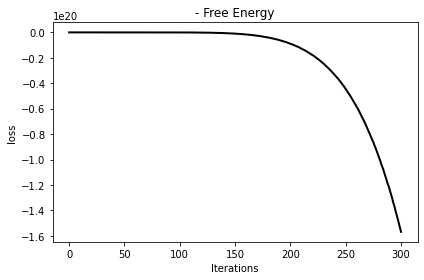

In [11]:
plot_loss(rpm, offset=0)

In [6]:
rpm.get_posteriors(obs_test)

ValueError: Incompatible Batch Dimensions

## Latent Distribution Embeddings of test images

In [2]:
# Forward test data
import utils_process
with torch.no_grad():
    rpm.num_observation_batch = obs_test[0].shape[0]
    rpm._update_factors(obs_test)

    
# Select One factor
J = 0
mean, vari = [
    xx[J].detach().clone().cpu().numpy()
    for xx in rpm.dist_factors.mean_covariance()
]


# Plot testing Data
subset = 250
xx = mean[:subset]
zz = vari[:subset]
yy = test_labels[:subset, J]
cmap = plt.get_cmap("tab10")


fig, ax = plt.subplots(figsize=(7, 7))
for ii in range(subset):
    y0 = int(yy[ii].numpy())
    x0 = xx[ii, 0]
    z0 = zz[ii, 0]
    plt.scatter(x0[0], x0[1], s=20, color=cmap(y0))
    utils_process.confidence_ellipse(x0, z0, ax, n_std=1.0, facecolor=cmap(y0), alpha=0.01)
    
for ii in np.unique(yy):
    y0 = yy[np.where(yy == ii)]
    x0 = xx[np.where(yy == ii)]
    plt.scatter(x0[0, 0, 0], x0[0, 0, 1], s=50, label=str(int(ii)), color=cmap(int(y0[0].numpy())))
plt.legend(title = 'Digit')
plt.xlabel('Z[1]')
plt.ylabel('Z[2]')
plt.title('Posterior Distribution f(. | x' + str(J) + ')')

NameError: name 'obs_test' is not defined